Никитина Наталья, РИМ-181226.

# Решающее дерево

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

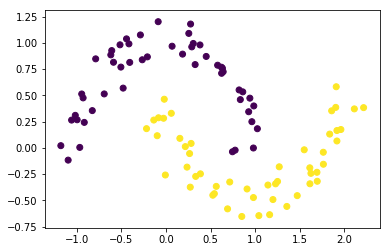

In [1]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(x[:,0], x[:,1], c = y)


## Задание 1

Напишите функцию, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$).
Постарайтесь учесть, что пороги разбиения должны лежать строго по середине между ближайшими обектами.

Необходимо учесть:

1. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
2. Количество различных классов объектов в целевой переменной может быть больше двух.


После первого разбиения мы считаем, что в листе дерева будет находиться класс объектов, которых больше всего в этом множестве. Реализуйте классификатор дерева решений в виде функции, которая получает на вход признаки объекта - $x$, на выходе метка класса - $y_{pred}$. Величину порога деления возьмите с точностью до 5 знака после запятой.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

In [6]:
class DecisionTree:

    weights={}

    def __init__(self, x, y, max_level=float('inf')):
        self.weights=self.train(x,y,0,max_level-1)
    
    def H(self,lr):
        return sum([(c/len(lr))*(1-(c/len(lr))) for c in np.unique(lr,return_counts=True)[1]])
    
    def loss(self,l, r):
        return len(l) * self.H(l) / (len(l) + len(r)) + len(r) * self.H(r) / (len(l) + len(r))
    
    def get_most_popular(self, y):
        values, counts = np.unique(y,return_counts=True)
        return values[np.argmax(counts)]
    
    def train(self, x, y, current_level, max_level):
        losses={}
        for j in range(len(x[0])):
            xf=x[:,j]
            for t in list(map(lambda t1, t2: (t1+t2)/2, sorted(xf)[:-1],sorted(xf)[1:])):
                l, r = y[xf<=t], y[xf>t]
                losses[j, t]=self.loss(l,r)

        min_j, min_t=sorted(losses.items(), key=lambda x: x[1])[0][0]
        
        xf=x[:,min_j]
        xl, yl = x[xf<=min_t,:], y[xf<=min_t]
        xr, yr = x[xf>min_t,:], y[xf>min_t]
        
        splt={'t':min_t, 'j': min_j, 'next':{'l':None, 'r':None}}
       

    
        splt['next']['l'] = yl[0] if len(np.unique(yl)) == 1 else \
                            self.train(xl,yl,current_level+1,max_level) if current_level < max_level else \
                            self.get_most_popular(yl)
        splt['next']['r'] = yr[0] if len(np.unique(yr)) == 1 else \
                            self.train(xr,yr,current_level+1,max_level) if current_level < max_level else \
                            self.get_most_popular(yr)

        return splt
    
    def predict(self, x):
        return np.array([self.pred(xi, self.weights) for xi in x])
        
    def pred(self, x, splt):
        next_splt=splt['next']['l'] if x[splt['j']] <= splt['t'] else splt['next']['r']
        return self.pred(x, next_splt) if isinstance(next_splt, dict) else next_splt

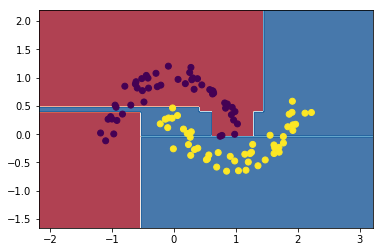

In [7]:
tree=DecisionTree(x,y)

h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree.predict(list(zip(xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

Проведите процесс разбиение в получившихся листах дерева до глубины 2. Перепишите функцию классификатора. Визуализируйте результаты классификации.

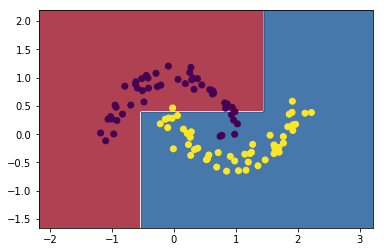

In [8]:
tree=DecisionTree(x,y,2)

h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree.predict(list(zip(xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)

## Задание №2. Кросс-проверка и  подбор параметров для дерева решений

В задании воспользуемся готовой функцией для построения дерева решений DecisionTreeClassifier. Использовать будем данные с платформы kaggle, где проводится классификация пациентов на здоровых ('Normal') и с заболеванием ('Abnormal'). Подробности о признаках тут: https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients/home
Необходимо построить кросс-проверку (cross_val_score в sklearn.cross_validation ) алгоритма "Дерево решений" на 5 подвыборках, причем дерево должно не ограничиваться по глубине (max_depth), в листовой вершине дерева должен быть хотя бы один объект (min_samples_leaf), минимальное количество объектов должно быть не менее 2 для разбиения (min_samples_split) и random_state=42.
Оцените результаты получившиеся на валидационной выборке с использованием F1-меры, точности и полноты (в параметре scoring к методу cross_val_score необходимо использовать 'f1_weighted', 'precision_weighted', 'recall_weighted'). 

Точность и полнота позволяют провести оценку классификации.
Точность (Precision) - это отношение количества правильно классифицированных объектов класса к количеству объектов, которые классифицированы как данный класс.
Полнота (Recall) - это отношение количества правильно классифицированных объектов класса к количеству объектов данного класса в тестовой выборке.
Введем следующие понятия:

$TP$  — истино-положительное решение;
$TN$ — истино-отрицательное решение;
$FP$ — ложно-положительное решение;
$FN$ — ложно-отрицательное решение.

Тогда 

$Precision = \frac{TP}{TP+FP}$, 

$Recall = \frac{TP}{TP+TN}$.

Точность и полнота изменяются в интервале [0, 1]. Чем выше точность и полнота, тем лучше классификатор. Однако, по двум метрикам очень сложно чудить о качестве классификации, поэтому используют F1-меру:

$F1 = \frac{2 \times Precision \times Recall}{Precision + Recall}$

В нашем задании будем использовать взвешенную сумму F1-меры, точности и полноты для каждого класса.

In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics.classification import f1_score, precision_score, recall_score

C:\Users\blueb\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
df = pd.read_csv('column_2C_weka.csv')
df.columns

Index(['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')

In [11]:
df.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [13]:
data=df[['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
target=df['class']

clf=DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)

print('Точность (Precision): %a' % cross_val_score(clf, data, target, cv=5, scoring= 'precision_weighted'))
print('Полнота (Recall): %a' % cross_val_score(clf, data, target, cv=5, scoring= 'recall_weighted'))
print('F1-мера: %a' % cross_val_score(clf, data, target, cv=5, scoring= 'f1_weighted'))

Точность (Precision): array([0.58570525, 0.71916509, 0.85275142, 0.92080961, 0.81075269])
Полнота (Recall): array([0.43548387, 0.67741935, 0.85483871, 0.91935484, 0.80645161])
F1-мера: array([0.42444379, 0.68732315, 0.85145657, 0.91747587, 0.79067321])


Следует отметить, что по одной метрике не очень удобно проводить оценку. В этой связи, лучшим вариантом кросс-проверки будет использование функции cross_validate из sklearn.model_selection. В нее можно передать несколько метрик и оценивать каждый шаг кросс проверки по нескольким метрикам, причем для тренировочного (return_train_score=True) и валидационного набора данных.
Оцените результаты на тренировочном и тестовом наборе. Объясните получившиеся результаты.


Исходя из полученных результатов видно, что на тестовой выборке модель переобучается вследствие неограниченного роста дерева.

In [15]:
from sklearn.model_selection import cross_validate

In [16]:
scores=['precision_weighted', 'recall_weighted','f1_weighted']
cross_validate(clf, data, target, scoring=scores, cv=5, return_train_score=True)

{'fit_time': array([0.0030005 , 0.00399613, 0.0040009 , 0.00399709, 0.00499701]),
 'score_time': array([0.00699615, 0.00599694, 0.00699258, 0.00899601, 0.00599599]),
 'test_precision_weighted': array([0.58570525, 0.71916509, 0.85275142, 0.92080961, 0.81075269]),
 'train_precision_weighted': array([1., 1., 1., 1., 1.]),
 'test_recall_weighted': array([0.43548387, 0.67741935, 0.85483871, 0.91935484, 0.80645161]),
 'train_recall_weighted': array([1., 1., 1., 1., 1.]),
 'test_f1_weighted': array([0.42444379, 0.68732315, 0.85145657, 0.91747587, 0.79067321]),
 'train_f1_weighted': array([1., 1., 1., 1., 1.])}

Результат совпадает с предыдущим: вследствие отсутствия ограничения максимальной глубины дерева модель переобучается, т.е. теряет способность к обобщению и результат на тестовой выборке становится хуже.

Подбор параметров для модели можно проводить с помощью GridSearchCV из sklearn.model_selection. Возьмите параметр максимальной глубины дерева от 1 до 20. Относительно этого параметра вычислите средевзвешенную F1-меру для 5 разбиений. Постройте график зависимости F1-меры от максимальной глубины дерева. Получить результаты построения можно методом cv_results_.

Проведите оценку результатов. Почему на тестовой выборке F1-мера не увеличивается. 

In [18]:
from sklearn.model_selection import GridSearchCV

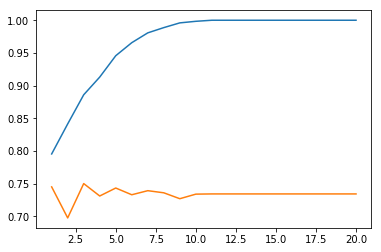

In [23]:
import matplotlib.pyplot as plt
depths=range(1, 21)
parameters = {'max_depth':depths}
gscv = GridSearchCV(clf, parameters, cv=5, scoring='f1_weighted',return_train_score=True)
gscv.fit(data, target)
plt.plot(depths, gscv.cv_results_['mean_train_score'])
plt.plot(depths, gscv.cv_results_['mean_test_score'])

Из полученных результатов видно, что при значениях максимальной глубины больше 10 происходит переобучение модели. С этим связано то, что F1-мера на тестовой выборке перестает изменяться.

То же самое проведите для параметра min_samples_split от 2 до 20.

Проведите оценку результатов. 

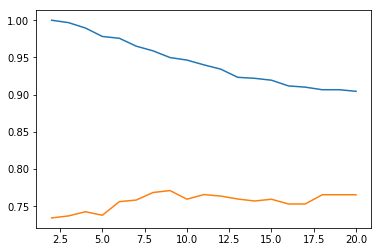

In [29]:
import matplotlib.pyplot as plt
splits=range(2, 21)
parameters = {'min_samples_split':splits}
gscv = GridSearchCV(clf, parameters, cv=5, scoring='f1_weighted',return_train_score=True)
gscv.fit(data, target)
plt.plot(splits, gscv.cv_results_['mean_train_score'])
plt.plot(splits, gscv.cv_results_['mean_test_score'])

То же самое проведите для параметра min_samples_leaf от 1 до 10.

Проведите оценку результатов. 

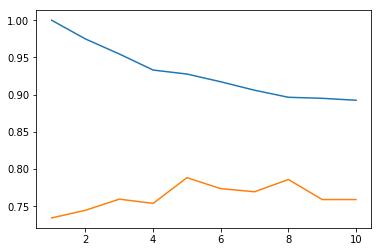

In [32]:
import matplotlib.pyplot as plt
leafs=range(1, 11)
parameters = {'min_samples_leaf':leafs}
gscv = GridSearchCV(clf, parameters, cv=5, scoring='f1_weighted',return_train_score=True)
gscv.fit(data, target)
plt.plot(leafs, gscv.cv_results_['mean_train_score'])
plt.plot(leafs, gscv.cv_results_['mean_test_score'])

Исходя из полученных результатов, видно, что отсутствует какая-либо определенная зависимость между параметрами минимального количества листов и разбиений и качеством кросс-валидации.